In [1]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms
import shelve
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import PIL
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import h5py
import os

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
path = "/content/gdrive/MyDrive/pcam/camelyonpatch_level_2_split_train_x.h5"
h5_img = h5py.File(path, "r")
ds_img = h5_img['x']
image = ds_img[0]

In [4]:
path2 = "/content/gdrive/MyDrive/pcam/camelyonpatch_level_2_split_train_y.h5"
h5_lbl = h5py.File(path2, "r")
ds_lbl = h5_lbl['y']

In [5]:
len(ds_img)

262144

Files and their types

`train_x.h5` : images

`train_y.h5` : labels (true/false)

`train_mask.h5` : masks of tumor locations

`train_meta.csv` : coords = ?, tumor patch t/f and if in center

In [7]:
class pcamDataset(Dataset):
  def __init__(self, images, labels):
    self.images = images
    self.labels = labels
    self.length = len(labels)
  def __len__(self):
    return self.length
  def __getitem__(self, idx):
    np_array = np.array(self.images[idx])
    image_tensor = torch.from_numpy(np_array)
    image_perm = image_tensor.permute(2, 0, 1)

    label = self.labels[idx]
    label_tensor = torch.tensor(label)

    sample = {'image': image_perm.float(), 'label': label_tensor.long()}
    return sample

In [ ]:
dset = pcamDataset(ds_img, ds_lbl)

In [ ]:
ds_img[0].shape

(96, 96, 3)

In [ ]:
dset.__getitem__(0)['image'].type

<function Tensor.type>

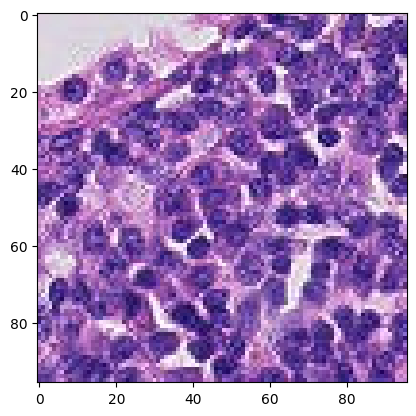

In [ ]:
plt.imshow(dset.__getitem__(0)['image'].permute(1, 2, 0).numpy().astype('uint8'))

In [ ]:
trainloader = DataLoader(dset, batch_size=256, shuffle=True, num_workers=2, pin_memory=True)

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.stack = nn.Sequential( # 2-3 conv w/ stride -> 2-3 lin, relu every layer + batchnorm in btw convs
      # [C, H, W]
      # [3, 96, 96] -> [32, 24, 24]
      nn.Conv2d(in_channels=3, out_channels=32, kernel_size=4, stride=4),
      nn.ReLU(),
      nn.BatchNorm2d(32),

      # [32, 24, 24] -> [16, 11, 11]
      nn.Conv2d(in_channels=32, out_channels=16, kernel_size=4, stride=2),
      nn.ReLU(),
      nn.BatchNorm2d(16),

      # [16, 11, 11] -> [8, 8, 8]
      nn.Conv2d(in_channels=16, out_channels=8, kernel_size=4),
      nn.ReLU(),
      nn.BatchNorm2d(8),

      # [n, 8, 8, 8] -> [512]
      nn.Flatten(),

      # [512] -> [64]
      nn.Linear(8*8*8, 64),
      nn.ReLU(),

      # [64] -> [16]
      nn.Linear(64, 16),
      nn.ReLU(),

      # [16] -> [8]
      nn.Linear(16, 8)
    )

  def forward(self, x):
    return self.stack(x)


In [ ]:
net = Net()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

Net(
  (stack): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(4, 4))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 16, kernel_size=(4, 4), stride=(2, 2))
    (4): ReLU()
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(16, 8, kernel_size=(4, 4), stride=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=512, out_features=64, bias=True)
    (11): ReLU()
    (12): Linear(in_features=64, out_features=16, bias=True)
    (13): ReLU()
    (14): Linear(in_features=16, out_features=8, bias=True)
  )
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [ ]:
loss_mem = []
net.train()
for i, data in enumerate(trainloader):
  image = data['image'].to(device)
  label = data['label'].view(-1).to(device)
  optimizer.zero_grad()
  output = net(image)
  loss = criterion(output, label)
  loss.backward()
  optimizer.step()
  loss_mem.append(loss.data.item())

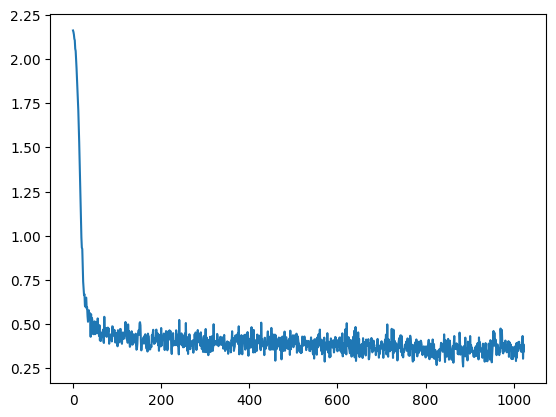

In [ ]:
plt.plot(loss_mem)

In [8]:
epoch = 3 # Change each training instance!
path = F"/content/gdrive/My Drive/checkpoints/2.ckpt" % epoch
torch.save({
            'epoch': epoch,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, path)

TypeError: ignored

In [ ]:
model = Net()
model_opt = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

checkpoint = torch.load("/content/gdrive/MyDrive/checkpoints/2.ckpt")
model.load_state_dict(checkpoint['model_state_dict'])
model_opt.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

In [9]:
path = "/content/gdrive/MyDrive/pcam/test/camelyonpatch_level_2_split_test_x.h5"
h5_img_test = h5py.File(path, "r")
ds_img_test = h5_img_test['x']

path = "/content/gdrive/MyDrive/pcam/test/camelyonpatch_level_2_split_test_y.h5"
h5_lbl_test = h5py.File(path, "r")
ds_lbl_test = h5_lbl_test['y']

test_dset = pcamDataset(ds_img_test, ds_lbl_test)
test_trainloader = DataLoader(test_dset, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)

In [10]:
len(ds_img_test)

32768

In [ ]:
net.to(device)
net.eval()
score = []
for i, data in enumerate(test_trainloader):
  image = data['image'].to(device)
  label = data['label'].view(-1).to(device)
  output = net(image)
  output_numpy = output.cpu().data.numpy()
  output_argmax = np.argmax(output_numpy, axis=1)
  labels_numpy = label.cpu().data.numpy()
  score = np.concatenate((score, (labels_numpy==output_argmax).astype(int)), axis=0)

meanAccuracy = sum(score)/len(score)
print(meanAccuracy)

0.655487060546875


0.780029296875 - 1st run
0.655487060546875 - 2nd run

avg = 0.72

Since binary choice, if we were randomly guessing the probability would be 50%. -> So learning did take place